#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [38]:
df_stock1 = pd.read_csv("../static/data/wes.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
8859,1/08/2022,46.590000,46.974998,46.220001,46.750000,46.750000,1963566.0,1.35,2.5,125.0
8860,2/08/2022,46.849998,47.590000,46.610001,47.570000,47.570000,1503797.0,1.35,2.5,125.0
8861,3/08/2022,47.150002,47.240002,46.549999,47.049999,47.049999,1629520.0,1.85,2.5,125.0
8862,4/08/2022,47.580002,47.810001,46.959999,47.000000,47.000000,1319580.0,1.85,2.5,125.0
8863,5/08/2022,47.200001,47.680000,47.110001,47.599998,47.599998,243025.0,1.85,2.5,125.0


In [39]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.wes.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.wes.insert_many(records)

In [40]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.wes.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.wes.delete_one(
    {'Date': last_date}
)

DELETE: 30/08/2022 47.70000076293945


In [41]:
first_val=df_mongo.iloc[:,1].values
first_date = first_val[0]
print("FIRST DATA VALUE: "+first_date.strip('/02'))

FIRST DATA VALUE: 1/02/1988


In [42]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.wes.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 29/08/2022 47.400001525878906
Previous last date in MongoDb: 29-08-2022. Today's date: 30-08-2022


In [43]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'WES.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-29,48.439999,47.270000,47.340000,47.400002,2030053,47.400002
2022-08-30,47.900002,47.419998,47.459999,47.700001,1964455,47.700001


In [44]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-30,47.900002,47.419998,47.459999,47.700001,1964455,47.700001


In [45]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
# print(a,b,c)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)
stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_37304/307716900.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_37304/307716900.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_37304/307716900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,30/08/2022,47.900002,47.419998,47.459999,47.700001,1964455,47.700001,1.85,2.5,125


UPDATE MONGO DB

In [46]:
records=stock_quote.to_dict('records')
records

[{'Date': '30/08/2022',
  'High': 47.900001525878906,
  'Low': 47.41999816894531,
  'Open': 47.459999084472656,
  'Close': 47.70000076293945,
  'Volume': 1964455,
  'Adj Close': 47.70000076293945,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125}]

In [47]:
#INSERT NEW DATA INTO MONGODB
db.wes.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.wes.find()))

last_val = df_mongo.iloc[-20:].values
print(last_val)

[[ObjectId('62eccae32574e28410ef13e8') '3/08/2022' 47.150002 47.240002
  46.549999 47.049999 47.049999 1629520.0 1.85 2.5 125.0]
 [ObjectId('62eccae32574e28410ef13e9') '4/08/2022' 47.580002 47.810001
  46.959999 47.0 47.0 1319580.0 1.85 2.5 125.0]
 [ObjectId('62f0d26a7b6fa16d568b6963') '05/08/2022' 47.20000076293945
  47.70000076293945 47.11000061035156 47.70000076293945 47.70000076293945
  947385.0 1.85 2.5 125.0]
 [ObjectId('62f21d8b0eb7abb42397fc14') '08/08/2022' 47.40999984741211
  47.470001220703125 46.689998626708984 46.75 46.75 1202724.0 1.85 2.5
  125.0]
 [ObjectId('62f370d64fe8cc535ec365ea') '09/08/2022' 46.849998474121094
  47.630001068115234 46.849998474121094 47.56999969482422
  47.56999969482422 1324474.0 1.85 2.5 125.0]
 [ObjectId('62f700018e06f07caad4343c') '10/08/2022' 47.02000045776367
  47.5 46.849998474121094 47.040000915527344 47.040000915527344 1333817.0
  1.85 2.5 125.0]
 [ObjectId('62f700018e06f07caad4343d') '11/08/2022' 47.400001525878906
  48.04999923706055 47.

In [48]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

30/08/2022 47.70000076293945


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [49]:
df_mongo = pd.DataFrame(list(db.wes.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(8715, 1)

In [50]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [51]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(6972, 1)

In [52]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 ,
       0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 ,
       0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 ,
       0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 ,
       0.0051691 , 0.0051691 , 0.00812286, 0.00812286, 0.00812286,
       0.00812286, 0.00812286, 0.00812286, 0.00812286, 0.00812286,
       0.00812286, 0.00812286, 0.00812286, 0.00812286, 0.00812286,
       0.00812286, 0.00812286, 0.00812286, 0.00812286, 0.00812286])]
[0.008122862643894602]


# Prepare train data for LSTM model

In [53]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(6912, 60)

In [54]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(6912, 60, 1)

# Build the LSTM model

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [56]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [57]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

6912/6912 [==============================] - 330s 47ms/step - loss: 1.6997e-04


In [58]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [59]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [60]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [61]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.21369051755571397

C:\Users\antoi\AppData\Local\Temp/ipykernel_37304/3379501223.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


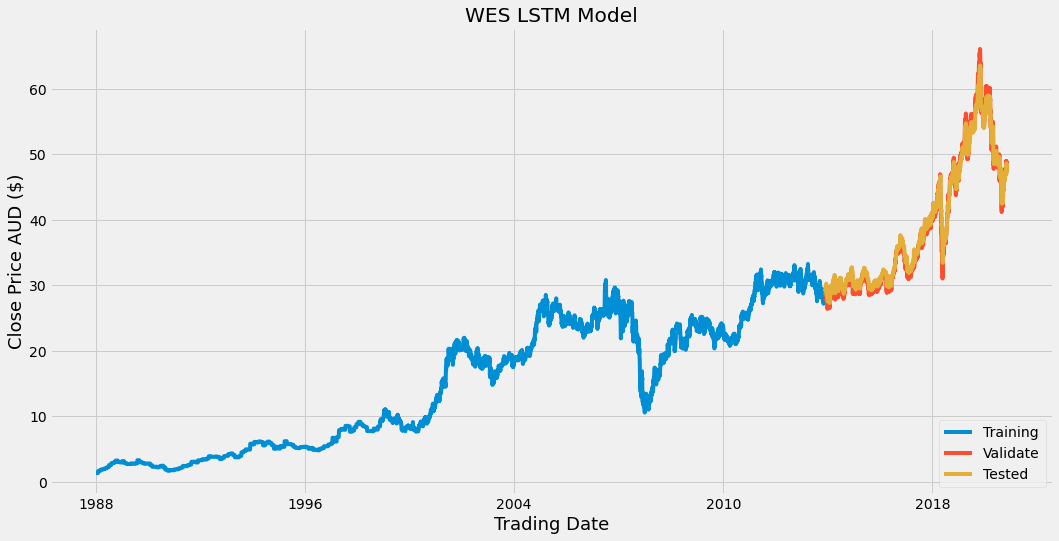

In [62]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('WES LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
# x = np.arange(2000,2024,4)
plt.xticks([0,2000,4000,6000,8000],[1988,1996,2004,2010,2018])
plt.savefig('../static/data/images/wes_graph.png')
plt.show()

# Test data Predictions on the Model

In [63]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_37304/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
6972  28.879684    29.061346   -0.181662
6973  28.630598    29.195261   -0.564663
6974  28.708883    29.164001   -0.455118
6975  28.801399    29.156998   -0.355599
6976  28.666182    29.201395   -0.535213
...         ...          ...         ...
8710  47.279999    47.528034   -0.248035
8711  47.639999    47.178722    0.461277
8712  47.950001    47.306286    0.643715
8713  47.400002    47.645195   -0.245193
8714  47.700001    47.569977    0.130024

[1743 rows x 3 columns]>

In [64]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.wes.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [65]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [66]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

30/08/2022 Last close $47.70000076293945 Predicted next day share price $47.35


# Save the Model

In [67]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/wes_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list wes_sixty and load df

#PREDICT USING LOADED MODEL

In [68]:
from keras.models import load_model
model_in = load_model('../static/wes_model.sav')

In [69]:
# query the wes collection and load into dataframe

df_mongo = pd.DataFrame(list(db.wes.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[45.52      ],
       [44.650002  ],
       [44.66      ],
       [43.669998  ],
       [40.029999  ],
       [41.59      ],
       [41.310001  ],
       [40.599998  ],
       [41.43      ],
       [42.209999  ],
       [42.150002  ],
       [42.985001  ],
       [43.130001  ],
       [43.990002  ],
       [42.459999  ],
       [42.080002  ],
       [41.91      ],
       [42.150002  ],
       [42.75      ],
       [42.82      ],
       [43.66      ],
       [43.880001  ],
       [44.27      ],
       [44.27      ],
       [44.540001  ],
       [44.700001  ],
       [45.279999  ],
       [44.860001  ],
       [45.669998  ],
       [45.959999  ],
       [46.290001  ],
       [46.549999  ],
       [47.150002  ],
       [46.68      ],
       [45.740002  ],
       [45.52      ],
       [46.209999  ],
       [46.470001  ],
       [46.220001  ],
       [46.610001  ],
       [46.549999  ],
       [46.959999  ],
       [47.11000061],
       [46.68999863],
       [46.84999847],
       [46

#Create a function to loop through the days input

In [70]:
from keras.models import load_model
model_in = load_model('../static/wes_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_wes(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_wes(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[47.19,
 47.21,
 47.19,
 47.16,
 47.12,
 47.1,
 47.07,
 47.03,
 47.03,
 47.02,
 47.02,
 47.02,
 47.02,
 47.02,
 47.02,
 47.01,
 47.0,
 47.0,
 47.01,
 47.01,
 47.03,
 47.04,
 47.05,
 47.07,
 47.08,
 47.09,
 47.1,
 47.11,
 47.12,
 47.12,
 47.12,
 47.13,
 47.13,
 47.13,
 47.14,
 47.14,
 47.14,
 47.15,
 47.15,
 47.15,
 47.15,
 47.15,
 47.16,
 47.16,
 47.16,
 47.16,
 47.17,
 47.17,
 47.17,
 47.18,
 47.18,
 47.19,
 47.19,
 47.19,
 47.19,
 47.19,
 47.18,
 47.18,
 47.18,
 47.18,
 47.18,
 47.17,
 47.17,
 47.17,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.16,
 47.

In [71]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  31-08-2022  Wednesday
1        2  01-09-2022   Thursday
2        3  02-09-2022     Friday
3        4  05-09-2022     Monday
4        5  06-09-2022    Tuesday
..     ...         ...        ...
203    204  12-06-2023     Monday
204    205  13-06-2023    Tuesday
205    206  14-06-2023  Wednesday
206    207  15-06-2023   Thursday
207    208  16-06-2023     Friday

[208 rows x 3 columns]>


In [72]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')


#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')

today_str=today1.strftime('%d-%m-%Y')

print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()

    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[-10:].values
    print(dates_val)


2022-08-31 00:00:00 2022-08-30 00:00:00
4:05:25.358215
[[ObjectId('630dc684ae0967d01293931d') 199 '05-06-2023' 'Monday']
 [ObjectId('630dc684ae0967d01293931e') 200 '06-06-2023' 'Tuesday']
 [ObjectId('630dc684ae0967d01293931f') 201 '07-06-2023' 'Wednesday']
 [ObjectId('630dc684ae0967d012939320') 202 '08-06-2023' 'Thursday']
 [ObjectId('630dc684ae0967d012939321') 203 '09-06-2023' 'Friday']
 [ObjectId('630dc684ae0967d012939322') 204 '12-06-2023' 'Monday']
 [ObjectId('630dc684ae0967d012939323') 205 '13-06-2023' 'Tuesday']
 [ObjectId('630dc684ae0967d012939324') 206 '14-06-2023' 'Wednesday']
 [ObjectId('630dc684ae0967d012939325') 207 '15-06-2023' 'Thursday']
 [ObjectId('630dc684ae0967d012939326') 208 '16-06-2023' 'Friday']]


In [73]:
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0:,1:]
# dates_df['Count'].dtype
# dates_df_iloc = dates_df.iloc[0:180,1:]
dates_val

,Count,Date,DOW
0,1,31-08-2022,Wednesday
1,2,01-09-2022,Thursday
2,3,02-09-2022,Friday
3,4,05-09-2022,Monday
4,5,06-09-2022,Tuesday
...,...,...,...
203,204,12-06-2023,Monday
204,205,13-06-2023,Tuesday
205,206,14-06-2023,Wednesday
206,207,15-06-2023,Thursday


In [74]:
# import pandas as pd
# dates_df = pd.read_csv("../static/data/dates.csv")
# dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
# dates_df

C:\Users\antoi\AppData\Local\Temp/ipykernel_37304/3965547979.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


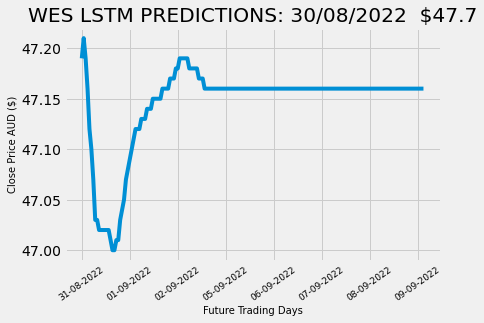

In [75]:
# DRAW THE PREDICTION
day1=dates_df.iloc[0,2]
day2=dates_df.iloc[1,2]
day3=dates_df.iloc[2,2]
day4=dates_df.iloc[3,2]
day5=dates_df.iloc[4,2]
day6=dates_df.iloc[5,2]
day7=dates_df.iloc[6,2]
day8=dates_df.iloc[7,2]
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('WES LSTM PREDICTIONS: '+last_date+"  $"+str(round(last_close,2)))
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/wes_pred.png', bbox_inches="tight")
plt.show()

In [76]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
print(my_dict[0])
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
# print(price_dict[0])

{'_id': ObjectId('630dc684ae0967d012939257'), 'Count': 1, 'Date': '31-08-2022', 'DOW': 'Wednesday', 'Price': 47.19}


In [77]:
len_df_mongo = len(df_mongo) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs

new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)
print(train_data_len,len_df_mongo,len_pred_df)


6972 8715 8878


C:\Users\antoi\AppData\Local\Temp/ipykernel_37304/1997212500.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


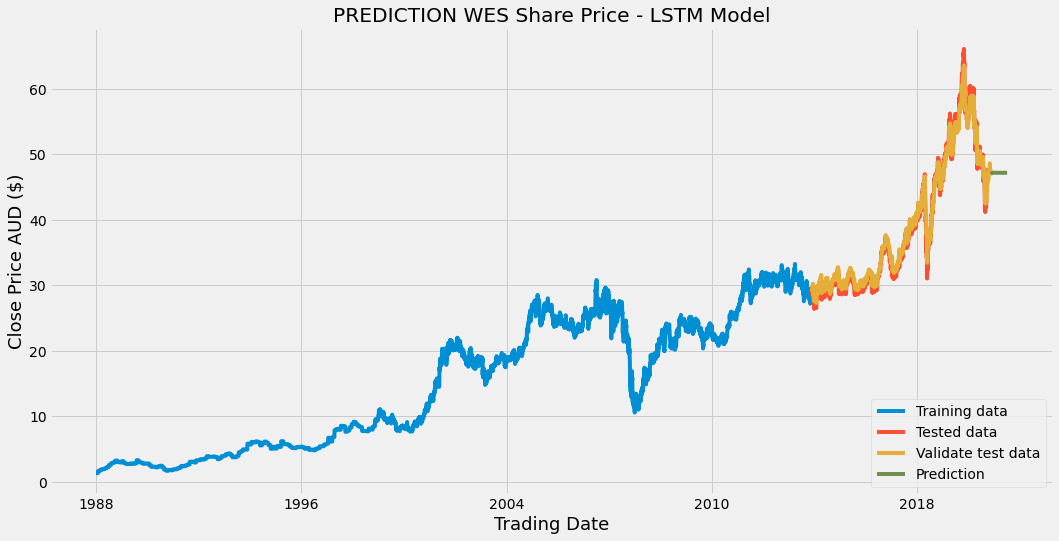

In [78]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION WES Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
# x = np.arange(2000,2024,4)
plt.xticks([0,2000,4000,6000,8000],[1988,1996,2004,2010,2018])
plt.savefig('../static/data/images/wes_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [79]:
# Query all
name = 'WES'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f86d4d5bc1b7bdfbac98f7'), 'model': 'RFR', 'name': 'WES', 'date': '12/08/2022', 'predicted': 45, 'actual': 47, 'difference': -1.9191, 'accuracy': 97.18}
{'_id': ObjectId('630c9b66d3173d3e00fa926d'), 'model': 'LSTM', 'name': 'WES', 'date': '29/08/2022', 'predicted': 48.97, 'actual': 47.4, 'difference': 1.57, 'rmse': 1.73803}


In [80]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f86d4d5bc1b7bdfbac98f7'), 'model': 'RFR', 'name': 'WES', 'date': '12/08/2022', 'predicted': 45, 'actual': 47, 'difference': -1.9191, 'accuracy': 97.18}


In [81]:
# Set keys and values of company
name = 'WES'
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 30/08/2022,predicted $47.35, actual $47.7, difference -0.3500000000000014, rmse 0.21369


In [82]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f86d4d5bc1b7bdfbac98f7'), 'model': 'RFR', 'name': 'WES', 'date': '12/08/2022', 'predicted': 45, 'actual': 47, 'difference': -1.9191, 'accuracy': 97.18}
{'_id': ObjectId('630dde5c45f6d161dac91353'), 'model': 'LSTM', 'name': 'WES', 'date': '30/08/2022', 'predicted': 47.35, 'actual': 47.7, 'difference': -0.35, 'rmse': 0.21369}


In [83]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'